# Create HDF5 DataFrame for S values from alphawave FEKO files
see: http://www.h5py.org/

+ This notebook was based on `RFcalcUC_v8.py` module
+ It is used for the **TE-007** spatial averaging working group calculations

## Set up

In [1]:
# import mayavi mlab
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'  # the 'qt4' option actually denotes qt4 and qt5
from mayavi import mlab

import sys
import pandas as pd
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
from collections import namedtuple
from scipy.interpolate import interp1d, interp2d, griddata
from icecream import ic
import warnings
pd.options.display.max_rows = 800
from traceback import print_exc
from RFcalcUC_v11 import *

import seaborn as sn
sn.set()
%matplotlib inline

# Set current working directory to the notebook folder
%cd -0

C:\Users\emeau\OneDrive\IT\Python\jupyter_notebooks\@Projects\spatial-averaging-wg\notebooks


## Functions

In [2]:
def h5store(filename, df, **kwargs):
    '''Save a DF with its metadata to a HDF5 file
       see: http://stackoverflow.com/questions/29129095/save-additional-attributes-in-pandas-dataframe
       INPUTS:
         filename = filename of the hdf5 file, including .hdf5 extension
               df = dataframe to be saved as hdf5 store
           kwargs = dict of metadata to store with the dataframe'''
    
    store = pd.HDFStore(filename)
    store.put('mydata', df)
    store.get_storer('mydata').attrs.metadata = kwargs
    store.close()   

def getgrid(df):
    '''Create a dataframe of a grid's characteristics:
       min, max, n, delta'''
    
    def n(arr):
        '''Return number of unique elements in array'''
        return arr.unique().size

    def max_delta(arr):
        '''Return dx, dy or dz increment between x, y or z points'''
        return np.diff(np.sort(np.unique(arr))).max()
   
    grid = df[['x','y','z']].agg(['min','max',n,max_delta]).T
    grid['n'] = grid.n.astype(int)
    return grid

def dB(x):
    return 10. * np.log10(x)

def make_mgrid(df,c):
    '''Make an xyz mgrid for column c'''
    df = df.sort_values(['x','y','z'])
    nx = len(df.x.unique())
    ny = len(df.y.unique())
    nz = len(df.z.unique())
    C = df[c].values.reshape(nx, ny, nz)
    return C

def compliance_zone(df, dat, lim, antcolor='blue', title =''):
    '''Generate a mayavi 3D compliamce zone
       df = source dataframe, e.g. S, SARdf
      dat = data column, e.g. 'SE', 'SARwb'
      lim = limit value for compliance zone
    title = title text for the plot'''

    # Generate mgrids for xyz and data
    X = make_mgrid(df,'x')
    Y = make_mgrid(df,'y')
    Z = make_mgrid(df,'z')
    F = make_mgrid(df,dat)

    # create the Mayavi figure
    from mayavi import mlab
    fig = mlab.figure(1, size=(1200,900), bgcolor=(0.5, 0.5, 0.5))
    mlab.clf()

    # draw the iso-surfaces
    src = mlab.pipeline.scalar_field(X, Y, Z, F, name=dat)
    mlab.pipeline.iso_surface(src, contours=[lim,], opacity=0.5)
    mlab.axes(x_axis_visibility=True, y_axis_visibility=True,
              z_axis_visibility=True, line_width=1)
    
    # Draw the panel antenna
    hyagi(antcolor)
    
    # print plot title
    height, size = 0.85, 0.5
    mlab.title(title, height=height, size=size)

    mlab.show()
    
def showgridpoints(df, fields=['SARwb'], axv=(True,False,False),
                   bgcolor='lightgrey', fgcolor='black', antcolor='blue'):
    '''Show S and SAR grid points
        df = dataframe
    fields = list of fields to display grid points for
       avx = X,Y,Z axis visibility flags (True/False,True/False,True/False)
   bgcolor = background color
   fgcolor = foreground color
  antcolor = color of the MBS panel antenna       
    '''
    from mayavi import mlab
    from collections.abc import Iterable
    
    # create the Mayavi figure
    fig = mlab.figure(1, size=(1200,900), 
                      bgcolor=COLORS[bgcolor],
                      fgcolor=COLORS[fgcolor])
    mlab.clf()

    # Make sure that fields is iterable
    if not isinstance(fields, Iterable): fields = [fields]

    # draw each of the field points
    possible_fields = df[3:].columns.to_list()
    for field in fields:
        assert field in possible_fields, f'field ({field}) must be one of {possible_fields}'

        # Get field grid point data
        dfd = df[['x','y','z',field]].dropna()

        # draw the field grid popints            
        pointcolor = COLORS['coral2'] if 'SAR' in field else COLORS['blue'] 
        mlab.points3d(dfd.x.values,dfd.y.values,dfd.z.values,
                      scale_factor=0.1,color=pointcolor,opacity=0.5)   # SAR grid

    # Get the extents
    g = df[['x','y','z']].agg(['min','max']).T
    extents = g.values.flatten().tolist()        

    # Add title
    title = 'grid points for: ' + ', '.join(fields)

    # draw the axes
    ax = mlab.axes(x_axis_visibility=axv[0], y_axis_visibility=axv[1],
                   z_axis_visibility=axv[2], line_width=1,
                   extent=extents,color=(0,0,0))
    ax.label_text_property.color = (0,0,0)
    ax.title_text_property.color = (0,0,0)
    ax.axes.label_format = '%g'
    ax.axes.font_factor = 1

    # Draw the panel antenna
    panelAntenna(antcolor)
    
    # Draw the scene
    mlab.title(title, height=0.85, size=0.15, color=COLORS[fgcolor])
    fig.scene.parallel_projection = True
    mlab.show()

## Look at model metadata for the spatial averaging trials

In [3]:
# Read in "calc uc trials.xls" spreadsheet
trials = pd.read_excel('../antennas/spat avg trials.xlsx', 'trials', 
                       skiprows=1, index_col=0).fillna('')
# trials.drop("unit", axis=1, inplace=True)

trials

,unit,1,2,3,4,5,6,7,8
INPUT,,,,,,,,,
fMHz,MHz,900,900,900,70,180,400,700,1000
antenna,,IEC 62232 panel antenna,IEC 62232 panel antenna,Yagi,Omni,Omni,Omni,Omni,Omni
Prad,W,80,200,100,100,100,100,100,100
dBiGain,,,,,7.37,7.38,7.38,7.38,7.38
horizHPBW,deg,,,,360,360,360,360,360
vertHPBW,deg,,,,20.3,20.3,20.3,20.3,20.3
coordinate_origin,,centre of the middle feed segment,centre of the middle feed segment,centre of rear reflector,centre of omni,centre of omni,centre of omni,centre of omni,centre of omni
xstart,m,0.5,-1,-1,0.05,0.05,0.05,0.05,0.05
xend,m,14,14,5,5.05,5.05,5.05,5.05,5.05


## Read in the E and H data from the FEKO zip files

In [4]:
# Set the trial number
trial = 3

# Get E and H FEKO data file locations
t = trials[str(trial)]
datadir = f'../antennas/{t.antenna_folder}/data/'
Efile = t.FEKO_Efile
Hfile = t.FEKO_Hfile

In [5]:
# Read in E-field FEKO data
print(f'{Efile = }')
Enames = ['x','y','z','Exr','Exi','Eyr','Eyi','Ezr','Ezi']
Edat = pd.read_csv(datadir + Efile, sep='\s+', skiprows=17, names=Enames)
Edat = Edat.sort_values(['x','y','z'])
display(Edat.head())

# Read in H-field FEKO data
print(f'{Hfile = }')
Hnames = ['x','y','z','Hxr','Hxi','Hyr','Hyi','Hzr','Hzi']
Hdat = pd.read_csv(datadir + Hfile, sep='\s+', skiprows=17, names=Hnames)
Hdat = Hdat.sort_values(['x','y','z'])
display(Hdat.head())

# Calculate SE, SH, Smax
SE = 0.5 * Edat.loc[:,'Exr':'Ezi'].pow(2).sum(axis=1) / 377
SH = 0.5 * Hdat.loc[:,'Hxr':'Hzi'].pow(2).sum(axis=1) * 377
Smax = np.max([SE,SH],axis=0)

S = pd.DataFrame(dict(x=Edat.x,y=Edat.y,z=Edat.z,SE=SE,SH=SH,Smax=Smax)).reset_index(drop=True)
S.head()

Efile = 'yagi_horizontal_900Mhz_100W_NearFieldforSAR.efe.zip'


,x,y,z,Exr,Exi,Eyr,Eyi,Ezr,Ezi
0,-1.0,-2.0,-3.0,-2.143688,1.107287,8.530842,-3.917288,-4.669190,2.489606
2501,-1.0,-2.0,-2.9,-1.387635,-2.170035,4.681666,8.183389,-2.978050,-4.541801
5002,-1.0,-2.0,-2.8,2.134836,-1.731783,-7.642128,5.564034,4.286894,-3.548374
7503,-1.0,-2.0,-2.7,2.135862,2.009311,-6.523453,-6.852355,4.177698,3.864449
10004,-1.0,-2.0,-2.6,-1.758395,2.585060,5.758408,-7.492851,-3.232091,4.824366


Hfile = 'yagi_horizontal_900Mhz_100W_NearFieldforSAR.hfe.zip'


,x,y,z,Hxr,Hxi,Hyr,Hyi,Hzr,Hzi
0,-1.0,-2.0,-3.0,0.024386,-0.011767,0.000619,-0.000326,-0.010097,0.004694
2501,-1.0,-2.0,-2.9,0.013998,0.023378,0.000397,0.000627,-0.005880,-0.010077
5002,-1.0,-2.0,-2.8,-0.021792,0.016565,-0.000620,0.000485,0.009789,-0.007315
7503,-1.0,-2.0,-2.7,-0.019345,-0.019466,-0.000590,-0.000592,0.008971,0.009120
10004,-1.0,-2.0,-2.6,0.016240,-0.022136,0.000533,-0.000709,-0.007938,0.010774


,x,y,z,SE,SH,Smax
0,-1.0,-2.0,-3.0,0.161726,0.161659,0.161726
1,-1.0,-2.0,-2.9,0.165805,0.165718,0.165805
2,-1.0,-2.0,-2.8,0.169610,0.169503,0.169610
3,-1.0,-2.0,-2.7,0.173072,0.172948,0.173072
4,-1.0,-2.0,-2.6,0.176124,0.175984,0.176124


## Check data

In [6]:
# Show compliance zone for Smax at pub WB limit
limit = Slimit(freq=900, setting='pub', standard='RPS S-1 WB')
title = f'Power = {t.Prad} W, Limit = {limit} W/m²'
print(title)
compliance_zone(df=S,dat='Smax',lim=limit, antcolor='yellow',
                title=title)

Power = 100 W, Limit = 4.5 W/m²


In [7]:
S2 = S.copy()
S2['Smax 0.15W'] = S2.Smax * 0.15/t.Prad
S2['Smax 12.5W'] = S2.Smax * 12.5/t.Prad
S2['Smax 1.55W'] = S2.Smax * 1.55/t.Prad
S2['Smax 200W'] = S2.Smax * 200/t.Prad
S2['Smax 120W'] = S2.Smax * 120/t.Prad

field = 'Smax 120W'
compliance_zone(df=S2,dat=field,lim=4.5, antcolor='yellow',
                title=field)
del(S2)

In [8]:
display(getgrid(S))
ic(len(S))

,min,max,n,max_delta
x,-1.0,5.0,61,0.1
y,-2.0,2.0,41,0.1
z,-3.0,3.0,61,0.1


ic| len(S): 152561


152561

## Get SAR data
This version only **interpolates** the SAR values

### Read in Danie's SAR data file
Note that this file is missing data at points where x = [0,0.25] and y = 0 which required an update in the interpolation function

In [10]:
# Read in csv data file
SARdf0 = pd.read_csv(datadir + t.SAR_file,
                     usecols=[0,1,2,4]).astype(float)
print('x values:', *SARdf0.x.unique())
print('y values:', *SARdf0.y.unique())
print('z values:', *SARdf0.z.unique(), '\n')

SARdf0

x values: -1.0 -0.5 -0.2 0.0 0.25 0.5 0.8 1.3 1.9 2.8 3.9 5.0
y values: 0.0 0.1 0.2 0.36 0.6 0.9 1.4 2.0
z values: -2.0 -1.35 -0.81 -0.3 0.0 0.3 0.81 1.35 2.0 



,x,y,z,SARwb
0,-1.0,0.0,-2.00,0.00183
1,-1.0,0.0,-1.35,0.00144
2,-1.0,0.0,-0.81,0.00166
3,-1.0,0.0,-0.30,0.00301
4,-1.0,0.0,0.00,0.00320
...,...,...,...,...
841,5.0,2.0,0.00,0.01230
842,5.0,2.0,0.30,0.01210
843,5.0,2.0,0.81,0.01130
844,5.0,2.0,1.35,0.00965


In [11]:
# check for zero values of SARwb
mask = (SARdf0.SARwb == 0)
SARdf0[mask]

,x,y,z,SARwb


In [12]:
# Check that SARdf is missing values at x = [0,0.25] and y = 0
mask = (SARdf0.x.isin([0,0.25])) & (SARdf0.y == 0)
SARdf0[mask]

,x,y,z,SARwb


In [13]:
# Show SAR grid info
display(getgrid(SARdf0))
ic(len(SARdf0))

,min,max,n,max_delta
x,-1.0,5.0,12,1.10
y,0.0,2.0,8,0.60
z,-2.0,2.0,9,0.65


ic| len(SARdf0): 846


846

In [14]:
# Add NaN values at the missing points
zpoints = SARdf0.z.unique()
mp = [[x,0,z,np.nan] for x in [0,0.25] for z in zpoints]
ff = pd.DataFrame(mp, columns=SARdf0.columns)
SARdf = pd.concat([SARdf0,ff]).sort_values(['x','y','z']).reset_index(drop=True)
SARdf = SARdf.astype(float)

### Show grid points for the SARwb data

In [15]:
show_grid_points(SARdf,fields=['SARwb'], axv=(True,True,False),hman=None,
                 antcolor='blue')

### Get characterstics of the S and SARdf grids

In [16]:
SARgrid = getgrid(SARdf)
Sgrid = getgrid(S)
display('SAR grid',SARgrid)
display('S grid',Sgrid)

ic(SARdf.x.unique(),SARdf.y.unique(),SARdf.z.unique());

'SAR grid'

,min,max,n,max_delta
x,-1.0,5.0,12,1.10
y,0.0,2.0,8,0.60
z,-2.0,2.0,9,0.65


'S grid'

,min,max,n,max_delta
x,-1.0,5.0,61,0.1
y,-2.0,2.0,41,0.1
z,-3.0,3.0,61,0.1


ic| SARdf.x.unique(): array([-1.  , -0.5 , -0.2 ,  0.  ,  0.25,  0.5 ,  0.8 ,  1.3 ,  1.9 ,
                              2.8 ,  3.9 ,  5.  ])
    SARdf.y.unique(): array([0.  , 0.1 , 0.2 , 0.36, 0.6 , 0.9 , 1.4 , 2.  ])
    SARdf.z.unique(): array([-2.  , -1.35, -0.81, -0.3 ,  0.  ,  0.3 ,  0.81,  1.35,  2.  ])


### Fill out the y<0 symmetry plane data

In [17]:
SARdfm = SARdf.copy()    # mirror copy
SARdfm['y'] = -SARdfm.y  # mirror the y values
SARdfall = pd.concat([SARdf, SARdfm])
SARdfall = SARdfall.drop_duplicates().sort_values(['x','y','z']).reset_index(drop=True)
SARdfall = SARdfall.astype({'y': 'float64','z':'float64'})

# check y symmetry for fixed x & z coordinates
mask = (SARdfall.x == 0) & (SARdfall.z == 0) 
SARdfall[mask]

,x,y,z,SARwb
409,0.0,-2.00,0.0,0.000234
418,0.0,-1.40,0.0,0.000925
427,0.0,-0.90,0.0,0.004700
436,0.0,-0.60,0.0,0.015100
445,0.0,-0.36,0.0,0.042600
454,0.0,-0.20,0.0,0.116000
463,0.0,-0.10,0.0,0.373000
472,0.0,0.00,0.0,NaN
481,0.0,0.10,0.0,0.373000
490,0.0,0.20,0.0,0.116000


### Interpolation functions

In [18]:
def axisvals(axis, delta, df):
    '''Generate points for axis in df for delta increment'''
    minval = df[axis].min()
    maxval = df[axis].max()
    return np.arange(minval, maxval+delta, delta).round(8)

def SARinterpolator1d(df, ax1, newaxisvals, kind):
    '''Interpolate SARwb values in df along specified x, y or z axis
    INPUTS:
      df = input dataframe
      ax1 = axis to intepolate along ['x', 'y' or 'z']
      newaxisvals = interpolation points along the ax1 axis
      kind = type of interpolation [linear, quadractic, cubic, etc]
    OUTPUTS:
      df1 = dataframe with interpolated SARwb values
      '''
    print(f'{kind} log interpolation along the {ax1} axis ...')
    
    # Get axis names for ax2, ax3
    other_axes = dict(x=('y','z'),y=('x','z'),z=('x','y'))
    ax2, ax3 = other_axes[ax1]
    
    # Create empty dataframe
    df1 = pd.DataFrame(columns=('x','y','z','SARwb')) # initialise empty dataframe
    
    # Groupby over ax2 and ax3 axes
    for (ax2val,ax3val), g in df.groupby([ax2, ax3]):
        
        # get xx, yy interpolation arrays and remove elements where yy is nan 
        xx = g[ax1].values.astype(np.float64)
        yy = g.SARwb.values.astype(np.float64)
        mask = np.isnan(yy)
        xx = xx[~mask]
        yy = yy[~mask]
        if 0 in yy:
            print(f'{ax2}={ax2val}, {ax3}={ax3val}')
            print(yy)           
        yy = np.log10(yy)
        
        # Create 1d interpolation function
        f = interp1d(xx, yy, kind=kind)
        ff = lambda newaxisvals: 10**f(newaxisvals)
    
        # do interpolation over ax1 axis
        SARwb = ff(newaxisvals)
        dfi = pd.DataFrame({ax1:newaxisvals, ax2:ax2val, ax3:ax3val, 'SARwb':SARwb})
        df1 = pd.concat([df1, dfi])
        
    df1 = df1.sort_values(['x','y','z']).reset_index(drop=True)
    return df1.astype(float)

### Interpolate SARdfall over x, y & z axes

In [19]:
# Set interpolation parameters
delta = 0.1                            # increment axis points
xnew = axisvals('x', delta, SARdfall)  # new x-value interpolation points
ynew = axisvals('y', delta, SARdfall)  # new y-value interpolation points
znew = axisvals('z', delta, SARdfall)  # new z-value interpolation points

# Conduct x, y and z axis interpolations
SARdfi_x = SARinterpolator1d(SARdfall,'x',xnew,'quadratic')
SARdfi_xy = SARinterpolator1d(SARdfi_x,'y',ynew,'quadratic')
SARdfi_xyz = SARinterpolator1d(SARdfi_xy,'z',znew,'quadratic')

# Rename SARwb to SARwbi
SARdfi_xyz.rename(columns={'SARwb':'SARwbi'},inplace=True)
display(SARdfi_xyz)

# Show SAR grid parameters
getgrid(SARdfi_xyz)

quadratic log interpolation along the x axis ...
quadratic log interpolation along the y axis ...
quadratic log interpolation along the z axis ...


,x,y,z,SARwbi
0,-1.0,-2.0,-2.0,0.001100
1,-1.0,-2.0,-1.9,0.001088
2,-1.0,-2.0,-1.8,0.001075
3,-1.0,-2.0,-1.7,0.001060
4,-1.0,-2.0,-1.6,0.001044
...,...,...,...,...
102536,5.0,2.0,1.6,0.008765
102537,5.0,2.0,1.7,0.008403
102538,5.0,2.0,1.8,0.008039
102539,5.0,2.0,1.9,0.007674


,min,max,n,max_delta
x,-1.0,5.0,61,0.1
y,-2.0,2.0,41,0.1
z,-2.0,2.0,41,0.1


In [20]:
# Check for any nans in SARwbi
mask = SARdfi_xyz.SARwbi.isnull()
SARdfi_xyz[mask]

,x,y,z,SARwbi


In [21]:
SARdfi_xyz.describe()

,x,y,z,SARwbi
count,102541.00000,1.025410e+05,1.025410e+05,102541.000000
mean,2.00000,-2.660871e-17,-1.316577e-18,0.023424
std,1.76069,1.183222e+00,1.183222e+00,0.042701
min,-1.00000,-2.000000e+00,-2.000000e+00,0.000198
25%,0.50000,-1.000000e+00,-1.000000e+00,0.004799
50%,2.00000,0.000000e+00,0.000000e+00,0.013284
75%,3.50000,1.000000e+00,1.000000e+00,0.025340
max,5.00000,2.000000e+00,2.000000e+00,0.826406


### Display SARdfi_xyz isocontour

In [22]:
compliance_zone(df=SARdfi_xyz,dat='SARwbi',lim=0.04, antcolor='yellow',
                 title=f'interpolated SARdfi_xyz values on {delta}m mesh')

### Check symmetry of SARdfi_xyz in the z direction

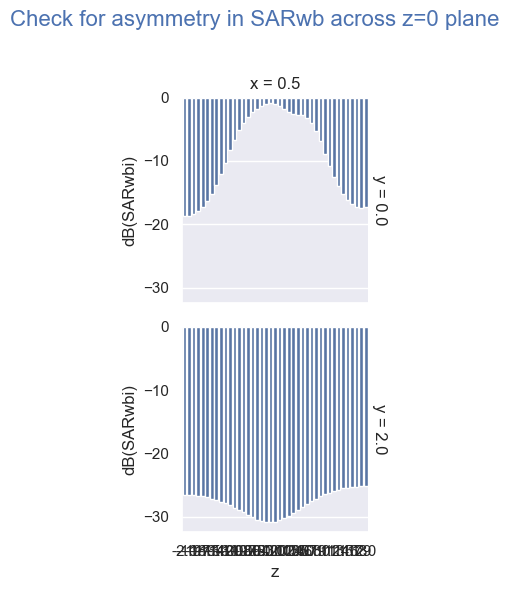

In [23]:
# Bar plots of dB(SARwb) along z for various values of x and y
SARdfi = SARdfi_xyz.copy()
SARdfi['dB(SARwbi)'] = dB(SARdfi.SARwbi)
xvals = [0.5,6.5,13]
yvals = [0,2,4,6]

mask = (SARdfi.x.isin(xvals)) & (SARdfi.y.isin(yvals))
g = sn.FacetGrid(SARdfi[mask], col="x", row="y",margin_titles=True)
g.map(sn.barplot, 'z', "dB(SARwbi)", order=np.sort(SARdfi_xyz.z.unique()))
plt.suptitle(f"Check for asymmetry in SARwb across z=0 plane\n",fontsize=16,c='b')
plt.tight_layout();

Data looks nicely symmetric in the z axis. It is *not* expected to be perfectly symmetric since the body phantom is not totally symmetric in the z direction and the folded dipole of the yagi is offset to one side

### Merge Sall and SARdfi_xyz with S
*Don't* merge in **SARdfall** since some of the SARwb points, e.g. y=0.36, x=0.81, are not on the 0.1m grid spacing

In [22]:
# Create Sall by merging SARwb and SARps from SARdf with S dataframe
Sall = S.merge(SARdfi_xyz,how='outer',on=['x','y','z']).sort_values(['x','y','z'],ignore_index=True)
Sall

,x,y,z,SE,SH,Smax,SARwbi
0,-1.0,-2.0,-3.0,0.161726,0.161659,0.161726,NaN
1,-1.0,-2.0,-2.9,0.165805,0.165718,0.165805,NaN
2,-1.0,-2.0,-2.8,0.169610,0.169503,0.169610,NaN
3,-1.0,-2.0,-2.7,0.173072,0.172948,0.173072,NaN
4,-1.0,-2.0,-2.6,0.176124,0.175984,0.176124,NaN
...,...,...,...,...,...,...,...
152556,5.0,2.0,2.6,0.778192,0.779280,0.779280,NaN
152557,5.0,2.0,2.7,0.726857,0.727911,0.727911,NaN
152558,5.0,2.0,2.8,0.677213,0.678232,0.678232,NaN
152559,5.0,2.0,2.9,0.629411,0.630397,0.630397,NaN


In [23]:
mask = Sall.Smax.isnull()
Sall[mask]

,x,y,z,SE,SH,Smax,SARwbi


In [28]:
compliance_zone(df=Sall,dat='Smax',lim=4.5, antcolor='yellow',
                title=f'interpolated SARdfi_xyz values on {delta}m mesh')

In [29]:
compliance_zone(df=Sall,dat='SARwbi',lim=0.08, antcolor='yellow',
                title=f'interpolated SARdfi_xyz values on {delta}m mesh')

In [31]:
show_grid_points(Sall,fields=['Smax','SARwbi'], 
                 antcolor='yellow', axv=(True,True,False))

In [22]:
# showgridpoints(Sall_filled,fields=['Smax'], axv=(True,True,False))

### Compare histogram of Danie's SARwb values with my log-quadratic interpolated values (SARwbi)

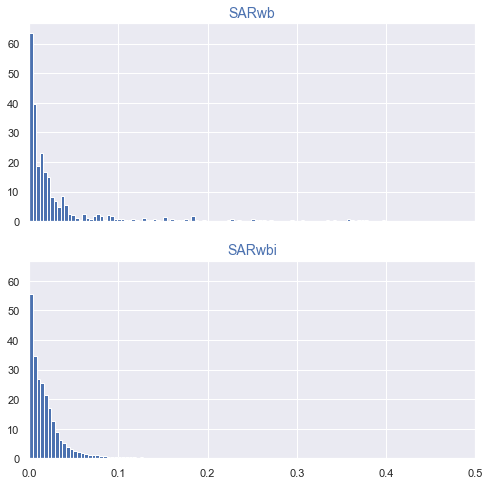

In [33]:
fig, ax = plt.subplots(2,1,sharex=True,sharey=True,figsize=(8, 8))
bins = 200
SARdfall.SARwb.hist(bins=bins,ax=ax[0],density=True)
Sall.SARwbi.hist(bins=bins,ax=ax[1],density=True)
ax[0].set_title('SARwb',fontsize=14,color='b')
ax[1].set_title('SARwbi',fontsize=14,color='b');
plt.xlim(0,0.5);

Danie's SAR data and my interpolated data have similar histogram distributions

Danie's SAR points (`SARwb`) all lie on the lines for my log-linear interpolated data (`SARwbi`)

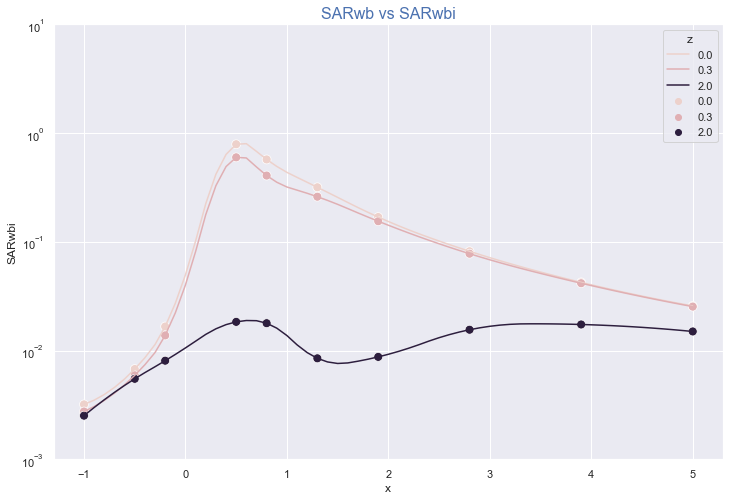

In [29]:
# Line plots of SARwb and SARwbi
fig, ax = plt.subplots(figsize=(12, 8))
y = 0
z = [0,0.3,2]
mask1 = (Sall.y == y) & (Sall.z.isin(z))
mask2 = (SARdfall.y == y) & (SARdfall.z.isin(z))
sn.lineplot(data=Sall[mask1],x='x',y='SARwbi',hue='z')
sn.scatterplot(data=SARdfall[mask2],x='x',y='SARwb',hue='z',s=80)
ax.set_yscale('log')
ax.set_ylim(top=10,bottom=0.001)
ax.set_title('SARwb vs SARwbi', fontsize=16, color='b')
fig.savefig('../antennas/HYagi/plots/hyagi interpolation check.png',dpi=150)

Danie's SAR points (`SARwb`) all lie on the lines for my log-linear interpolated data (`SARwbi`)

## Metadata for Sall dataframe 

In [36]:
# Create dict for S column name metadata
Snames = {'SE': 'S(E) levels',
          'SH': 'S(H) levels',
          'Smax': 'Smax levels',
          'SARps': 'peak spatial SAR',
          'SARwb': 'WBA SAR',
          'SARwbi': 'WBA SAR (interpolated)',
         }

## Save the S DataFrame as hdf5 store with metadata

In [37]:
# Set the file name of the hdf5 store
Sfile = datadir + f'{t.antenna_folder}.hdf5'

# Save the data into an hdf5 store (without x,y,z data)
Sdata = Sall.drop(columns=['x','y','z'])
h5store(Sfile, Sdata, **Snames)
print(f'S DataFrame saved to: {Sfile}')
print(f'{len(Sall) = }')

S DataFrame saved to: ../antennas/Hyagi/data/Hyagi.hdf5
len(Sall) = 152561


## Scratch